FIDE Chess Machine Learning
---

Frame the Problem and Look at the Big Picture
---

**1. Define the objective in business terms.**

The objective of this problem is to discover interesting trends in the world of competitive chess. FIDE will be focused on rather than national chess organizations because they have the toughest competition. FIDE is where who will be the next world champion is decided. We want to predict who the next world chess champion is going to be. We also want to figure out what the record for the highest ELO is going to be (whether it will break the current ceiling or not). We want to find out what chess players are trending in a good direction for breaking the current ceiling (setting a record) and becoming world champion. We also want to find out what countries will generate the next best players.

**2. How will your solution be used?**

Our solution can be used for a variety of ways from determining specific statistics and trends about current players to studying how players become better at chess overtime depending on age, gender and country of origin. Our dataset can be used by worldwide chess federations to determine how to grow and get better players.

**3. What are the current solutions/workarounds (if any)?**

There are no currently existing solutions. There are however machine learning solutions for a computer to play chess. These solutions are highly effective and computers are extremely strong at chess. This could possibly help us if we applied this to analyzing games of different players to find trends.

**4. How should you frame this problem (supervised/unsupervised, online/offline, ...)?**

This is a supervised regression problem because we are using historical data to predict a continuous feature. The system should be offline as the data is only updated around every year. This could also be done as a classification problem because we are trying to figure out if someone will be world champion or not. However, the world champion is most likely just going to be the person with the highest rating. But this does not necessarily always need to be true, especially in the future. This part might be able to be classification if we create a second model that we feed the results of the first model (the one that predicts ELO) into.

**5. How should performance be measured? Is the performance measure aligned with the business objective?**

Performance on the predicted ELO can be measured by measuring the mean square error of the predictions. Because this is a forecasting problem, we would take a window of our data instead of a test set. For the classification part, the performance can be measured by taking the accuracy of the predictions. The performance will definitely be aligned with our business objective since we want to accurately predict future ELO and accurately predict future world chess champions.

**6. What would be the minimum performance needed to reach the business objective?**

The minimum performance needed to reach the business objective could be subjected to the idea that we want our solution to be very accurate in at least placing players within a range of 10-20 rank for where they will be placed for coming years. If we can achieve accuracy where we can label what countries have the most prolific chess players and label what countries are achieving the most growth that would be a good place to start with the idea of minimum performance.

**7. What are comparable problems? Can you reuse experience or tools?**

When jumping into this problem the first thing that came to my mind in terms of comparable problems was the housing income problem where we ultimately tried to discover interesting remarks about the housing income and prices in a specified area. Taking this into account we can look at how that problem can be somewhat comparable as we are taking individuals (houses) from specific countries (locations) and seeing what their value / skill is to the game of chess (price). Weather forecasting is also somewhat similar.

**8. Is human expertise available?**
Chess is a very popular hobby / sport in which millions of people take part in. There are tons of very good developers that have made projects similar to ours so that may be of use to us. There is human expertise in the form of chess grandmasters and commentators. They understand the players as people and they understand their playing styles. They can predict rank/world champion based on this criteria.

**9. How would you solve the problem manually?**

The problem could be solved manually by first finding out whether someone has peaked or not. If someone has peaked then they can be ruled out for increasing ELO or becoming world chess champion. Most younger players definitely have not peaked. This is the group that is the most interesting and promising for future world champions. We could find the fastest growing younger players and simply choose one of them as a candidate for future world championships.

**10. List the assumptions you (or others) have made so far. Verify assumptions if possible.**

The assumptions that we have made so far would include that all of the data provided is accurate and updated correctly. This includes players’ age, gender, ELO rating, country of origin and title.


In [1]:
import ast

import numpy as np
import scipy.sparse
import scipy as sp
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

Get the Data
---
**1. List the data you need and how much you need**

For our problem we will need a whole set of data about all types of demographics, ratings, and names of all players that are listed and rated under FIDE... On top of that it would be beneficial to have multiple years included with all of this data alongside it.

**2. Find and document where you can get that data** 

We will most likely end up using data that is compiled on a website called kaggle. The link is posted below.

https://www.kaggle.com/datasets/rohanrao/chess-fide-ratings?select=players.csv

**3. Get access authorizations** 

Kaggle datasets are publically avaliable

**4. Create a workspace (with enough storage space)** 

VSCode Jupyter Notebooks

**5. Get the data** 

Done

**6. Convert the data to a format you can easily manipulate (without changing the data itself)** 

Currently in csv format which is easily usable

**7. Ensure sensitive information is deleted or protected (e.g. anonymized)** 

Done

**8. Check the size and type of data (time series, geographical, ...)** 

around 200.5 MbS..

**9. Sample a test set, put it aside, and never look at it (no data snooping!)** 

Explore the Data 
---

In [5]:
def load_players_data():
    """
    Loads the CSV file which contains our data for players.
    """
    return pd.read_csv('players.csv')

def load_ratings(year):
    """
    These functions load each individuals years data,
    """
    return pd.read_csv('ratings_' + str(year) + '.csv')

**1. Copy the data for exploration, downsampling to a manageable size if necessary.**

In [6]:
players = load_players_data()
year_15 = load_ratings(2015)
year_16 = load_ratings(2016)
year_17 = load_ratings(2017)
year_18 = load_ratings(2018)
year_19 = load_ratings(2019)
year_20 = load_ratings(2020)
year_21 = load_ratings(2021)

In [7]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433388 entries, 0 to 433387
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   fide_id     433388 non-null  int64 
 1   name        433388 non-null  object
 2   federation  433388 non-null  object
 3   gender      433388 non-null  object
 4   title       19498 non-null   object
 5   yob         433388 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 19.8+ MB


In [10]:
players.describe()

,fide_id,yob
count,4.333880e+05,433388.000000
mean,1.979331e+07,1940.034408
std,5.138192e+07,290.260909
min,1.000130e+05,0.000000
25%,2.510166e+06,1966.000000
50%,1.232708e+07,1986.000000
75%,2.500971e+07,2001.000000
max,6.510818e+08,2015.000000


In [43]:
players.head(20)

,fide_id,name,federation,gender,title,yob
0,100013,"Campora, Daniel H.",ARG,M,GM,1957
1,100021,"Quinteros, Miguel A.",ARG,M,GM,1947
2,100048,"Iapichello, Javier",ARG,M,NaN,1990
3,100064,"Schipper, Bernardo",ARG,M,NaN,2000
4,100072,"Adla, Diego",ARG,M,IM,1968
5,100080,"Bianchi, Guillermo",ARG,M,IM,1958
6,100102,"Cid, Marino Alejandro",ARG,M,IM,1958
7,100110,"Sanchez Almeyra, Jorge",ARG,M,IM,1968
8,100129,"Gomez Baillo, Jorge H.",ARG,M,IM,1959
9,100137,"Zarnicki, Pablo",ARG,M,GM,1972


Players
---
The 'fide_id' column is a categorical attribute. It is a unique integer that represents a players id. This is a useful attribute for identifying the different players.  
The 'name' column is a text attribute that has the player's name.  
The 'federation' column is a categorical text attribute. It has the federation the player is a part of.  
The 'gender' column is a categorical text attribute. It has the gender of the player.
The 'title' column is a categorical text attribute. It has the title of the player. It is NaN if the player is untitled.
The 'yob' column is a numerical integer column. It has the year the player was born.

In [8]:
title_values = players['title'].value_counts().reset_index()
title_values

,index,title
0,FM,8245
1,IM,3887
2,CM,1898
3,WFM,1758
4,GM,1727
5,WIM,837
6,WCM,781
7,WGM,318
8,NI,23
9,DI,17


In [9]:
year_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680191 entries, 0 to 2680190
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   fide_id          int64  
 1   year             int64  
 2   month            int64  
 3   rating_standard  float64
 4   rating_rapid     float64
 5   rating_blitz     float64
dtypes: float64(3), int64(3)
memory usage: 122.7 MB


In [12]:
year_15.describe()

,fide_id,year,month,rating_standard,rating_rapid,rating_blitz
count,2.680191e+06,2680191.0,2.680191e+06,2.554932e+06,621048.000000,506504.000000
mean,1.118616e+07,2015.0,6.676958e+00,1.828016e+03,1828.961328,1866.914099
std,1.291850e+07,0.0,3.449523e+00,3.034101e+02,310.426087,303.837760
min,1.000130e+05,2015.0,1.000000e+00,1.001000e+03,1000.000000,1000.000000
25%,1.515837e+06,2015.0,4.000000e+00,1.627000e+03,1620.000000,1666.000000
50%,4.655672e+06,2015.0,7.000000e+00,1.856000e+03,1841.000000,1881.000000
75%,1.990007e+07,2015.0,1.000000e+01,2.053000e+03,2044.000000,2074.000000
max,3.832667e+08,2015.0,1.200000e+01,2.876000e+03,2873.000000,2948.000000


**2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...)** 



Ratings
---


**3. For supervised learning tasks, identify the target attribute(s)**

**4. Visualize the data** 

In [51]:
def find_player(player_name):
    return players[players['name'].str.find(player_name) != -1]

In [53]:
find_player('Iyer, Tanishq')

,fide_id,name,federation,gender,title,yob
352061,30942829,"Iyer, Tanishq",USA,M,NaN,2001


In [31]:
federation = players[['federation']].value_counts(dropna=False).sort_values(ascending=False).head(10)
title = players[['title']].value_counts(dropna=False).sort_values(ascending=False).head(9)
list_title = list(title.keys())

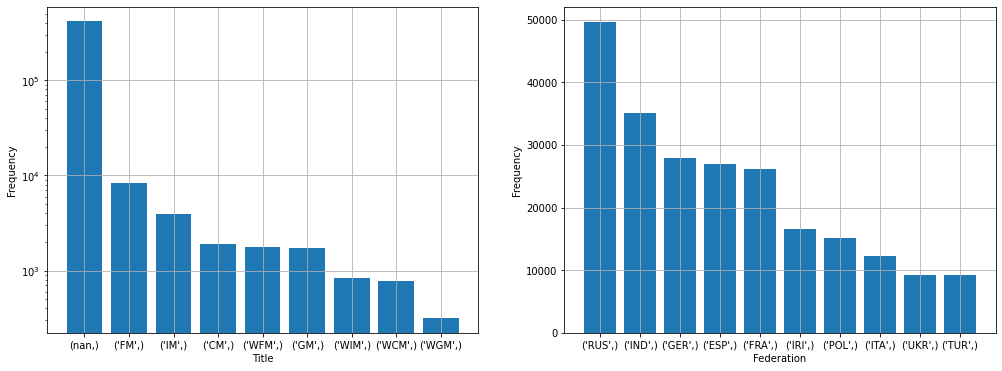

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
# Count of titles
axs[0].bar(range(9), title)
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].set_xlabel('Title')
axs[0].grid()
axs[0].set_xticks(range(9))
axs[0].set_xticklabels(list_title)

# Count of players by federation
axs[1].bar(range(10), federation)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Federation')
axs[1].grid()
axs[1].set_xticks(range(10))
axs[1].set_xticklabels(federation.keys());

**5. Study the correlations between attributes** 

**6. Study how you would solve the problem manually** 

**7. Identify the promising transformations you may want to apply** 

**8. Identify extra data that would be useful (go back to “Get the Data”)** 

**9. Document what you have learned** 